#1- Proyecto de clasificacion Bayesiana con Indian Pines.

En el siguiente notebook se cuenta con una base datos de imágenes hiperespectrales de un único paisaje de Indiana Estados Unidos, este dataset es conocido como Indian Pines, este cuenta con 145 x 145 X 200, donde los dos primeros numeros son las dimensiones de alto, ancho por número de pixeles y por último se tiene la profundidad de cada pixel en canales o bandas de reflectancia espectral, por otro lado la base datos tiene su mapa de clasificación o etiquetas. 

En este trabajo se implementan las siguientes características:

1.   Un analisis exploratorio de los datos.
2.   Partición del conjunto de datos en muestras en entrenamiento (Train) y Validación (Test).
3. Entrenamiento de un clasificador Bayesiano con y sin PCA (analisis de componentes principales).

Por último se mide la presición del clasificador, teniendo en cuenta la implentación o no implementación del PCA comparando los resultados. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/maestria/semestre_3/Tratamiento_matematico'

/content/drive/MyDrive/maestria/semestre_3/Tratamiento_matematico


\begin{equation}
\begin{array}{ccc}
\hline \text { Nombre de la capa/ ingreso de la capa } & \text { Kernel \#/ Tamaño } & \text { Componentes } \\
\hline\left[\begin{array}{c}
\text { Res-Conv-1 } \\
w \times w \times C
\end{array}\right] & {\left[\begin{array}{c}
\mathrm{CNN}, 24 \\
1 \times 1 \times 7
\end{array}\right] \times 3} & \text { BN, P-ReLu, Add } \\
{\left[\begin{array}{c}
\text { Conv-1 } \\
w \times w \times C^1 \times 24
\end{array}\right]} & {\left[\begin{array}{c}
\mathrm{CNN}, 128 \\
1 \times 1 \times C^1
\end{array}\right]} & \text { BN, P-ReLu } \\
{\left[\begin{array}{c}
\text { Reshape } \\
w \times w \times 1 \times 128
\end{array}\right]} & - \\
{\left[\begin{array}{c}
\text { Res-Conv-2 } \\
w \times w \times 128 \times 1
\end{array}\right]} & {\left[\begin{array}{c}
\mathrm{CNN}, 24 \\
3 \times 3 \times 128
\end{array}\right] \times 3} & \text { BN, P-ReLu, Add } \\
{\left[\begin{array}{c}
\text { Average pooling } \\
w^1 \times w^1 \times 1 \times 24
\end{array}\right]} & w^1 \times w^1 & - \\
{\left[\begin{array}{c}
\text { Center coordinates } \\
1 \times 1 \times 1 \times 24
\end{array}\right]} & \mathrm{FC}, 2 & \text { BN, P-ReLu } \\
{\left[\begin{array}{c}
\text { Class probability } \\
2
\end{array}\right]} & \mathrm{FC}, L & \text { Softmax } \\
\hline
\end{array}
\end{equation}

In [ ]:
import os # para navegar por el sistema operativo sin problemas
import scipy.io # libreria para transfomrar los datos de .mat 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Se cargan los datos para ser leidos.
image_path = 'Indian_pines_corrected.mat' # se carga la ruta desde drive
gt_path = 'Indian_pines_gt.mat' # se cargan las etiquetas 

img = scipy.io.loadmat(image_path) 
img = img['indian_pines_corrected']
labels = scipy.io.loadmat(gt_path)
labels = labels['indian_pines_gt']
#labels = np.reshape(labels,labels.shape[0]*labels.shape[1])

In [ ]:
labels.shape

(145, 145)

In [ ]:
# Se hace el redimensionamiento de los datos para poder procesarlos sin la información espacial de la imagen.
img_r = np.reshape(img,(img.shape[0]*img.shape[1],img.shape[2]))
labels_r = np.reshape(labels,(labels.shape[0]*labels.shape[1]))

In [ ]:
labels_r.shape

(21025,)

In [ ]:
print('Dimensión de la base datos: ',img_r.shape)
print('Número de etiquetas por clase: ',labels_r.shape)

Dimensión de la base datos:  (21025, 200)
Número de etiquetas por clase:  (21025,)


In [ ]:
# Se obotiene la base de datos para visualizarla en un dataframe
indian=pd.DataFrame(img_r)
indian['class']=labels_r

Se elimina la clase 0 que hace referencia a al suelo en general de la imagen hiperespectral, en este caso no tiene importancia clasificarlo debido a que no tiene información importante.


In [ ]:
# Se elimina la clase 0 de la base datos
data_x = indian[indian['class'] != 0]
img_r = data_x.iloc[:, :-1].values
labels_r = data_x.loc[:, 'class'].values

In [ ]:
print ('total de muestras:', indian['class'].count())
print ('total de muestras por clase: ', indian['class'].value_counts())

total de muestras: 21025
total de muestras por clase:  0     10776
11     2455
2      1428
14     1265
10      972
3       830
6       730
12      593
5       483
8       478
15      386
4       237
13      205
16       93
1        46
7        28
9        20
Name: class, dtype: int64


In [ ]:
indian

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020,2561,3987,4011,4023,4201,4377,4418,4248,4180,3838,...,1013,1012,1018,1015,1011,1001,1000,1009,1008,0
21021,2726,4104,4024,3880,4210,4377,4413,4174,4229,3900,...,1012,1014,1012,1024,998,1010,1006,1000,1000,0
21022,3153,3864,4282,3889,4310,4372,4375,4208,4096,3878,...,1016,1015,1016,1021,1008,1019,1003,1008,1000,0
21023,3155,4104,4106,4027,4139,4318,4413,4174,4140,3933,...,1005,1011,1008,1012,1014,1007,1011,1005,1003,0


Esta información nos da informacion acerca de nuestros datos. Donde se tiene informacion espectral de cada banda.

In [ ]:
indian.describe()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,class
count,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,...,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000
mean,2957.363472,4091.321237,4277.502259,4169.956671,4516.678668,4790.595149,4848.317574,4714.732509,4668.904828,4439.065541,...,1061.927848,1060.210273,1063.276813,1050.048514,1040.201141,1043.370321,1030.194816,1015.571463,1008.513579,4.224923
std,354.918708,230.390005,257.827640,280.761254,346.035984,414.382138,469.247667,491.728349,533.232855,539.908195,...,38.843805,38.712195,41.920969,34.242725,26.452672,29.794418,20.865106,11.386402,7.050921,5.281972
min,2560.000000,2709.000000,3649.000000,2810.000000,3840.000000,4056.000000,4004.000000,3865.000000,3775.000000,2792.000000,...,998.000000,999.000000,999.000000,993.000000,990.000000,992.000000,989.000000,986.000000,981.000000,0.000000
25%,2602.000000,3889.000000,4066.000000,3954.000000,4214.000000,4425.000000,4421.000000,4263.000000,4173.000000,3940.000000,...,1026.000000,1024.000000,1024.000000,1019.000000,1016.000000,1016.000000,1012.000000,1006.000000,1004.000000,0.000000
50%,2780.000000,4106.000000,4237.000000,4126.000000,4478.000000,4754.000000,4808.000000,4666.000000,4632.000000,4404.000000,...,1053.000000,1052.000000,1054.000000,1043.000000,1033.000000,1035.000000,1026.000000,1014.000000,1009.000000,0.000000
75%,3179.000000,4247.000000,4479.000000,4350.000000,4772.000000,5093.000000,5198.000000,5100.000000,5084.000000,4860.000000,...,1099.000000,1098.000000,1104.000000,1083.000000,1066.000000,1072.000000,1050.000000,1024.000000,1014.000000,10.000000
max,4536.000000,5744.000000,6361.000000,6362.000000,7153.000000,7980.000000,8284.000000,8128.000000,8194.000000,7928.000000,...,1287.000000,1289.000000,1315.000000,1258.000000,1201.000000,1245.000000,1167.000000,1076.000000,1036.000000,16.000000


In [ ]:
copia_indian= indian.copy()


In [ ]:
from sklearn.model_selection import train_test_split # divide matrices en conjuntos de test y entrenamiento
from sklearn.pipeline import Pipeline # contruye lógicamente un proceso dividido en partes
from sklearn.model_selection import GridSearchCV # busca de manera exhaustiva los valores de los parametros del estimador
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from numpy import var

Partición del conjuntode datos en muestras de validación(test) y entrenamiento (train), donde se tiene un 20% de muestras de validación. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_r, labels_r, test_size=0.2, random_state=42, stratify = labels_r,shuffle=True)
print('Class label counts train:', np.bincount(y_train))
print('Class label counts test:', np.bincount(y_test))

Class label counts train: [   0   37 1142  664  190  386  584   23  382   16  778 1964  474  164
 1012  309   74]
Class label counts test: [  0   9 286 166  47  97 146   5  96   4 194 491 119  41 253  77  19]


(10249, 200)


Text(0.5, 1.0, 'Datos dispersos')

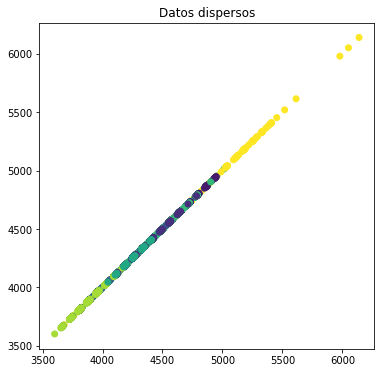

In [ ]:
xm = img_r
yl = labels_r
print(xm.shape)
plt.figure(1,figsize = (6,6))
plt.scatter(xm[:,3], xm[:,3], c = yl)
plt.title("Datos dispersos")

Implementación del clasificador Bayesiano con una presición aproximada del 50%

In [ ]:
Gausian_naive_bayes = GaussianNB()
y_pred = Gausian_naive_bayes.fit(X_train, y_train).predict(X_test)

precission = accuracy_score(y_test,y_pred)

print(f"La precisión alcanzada por el clasificador es: {precission*100} %")

La precisión alcanzada por el clasificador es: 50.24390243902439 %


Porcentaje de de precisión alcanzada con el clasificador sin uso de PCA.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


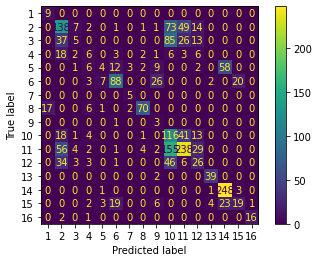

In [ ]:
plot_confusion_matrix(Gausian_naive_bayes,X_test, y_test) 


Matriz de confusión para ver que tan bien están clasificadas las muestras con sus clases.

2. Implementación del PCA en la base datos de indian pines, donde se hallan los valores y los vectores propios.

In [ ]:
S = xm.T@xm
#print(S)
vectores,valores,V = np.linalg.svd(S)
print('Los vectores propios son:\n ',vectores.shape)
print('Los valores propios son:\n ',valores.shape )

ValuesNorm = valores/np.sum(valores)
print(ValuesNorm)

Los vectores propios son:
  (200, 200)
Los valores propios son:
  (200,)
[1.26765520e-01 1.01416867e-02 1.00094123e-02 9.98337123e-03
 9.87063621e-03 9.61273198e-03 9.59572978e-03 9.47246112e-03
 9.40048805e-03 9.27631227e-03 9.14799405e-03 9.13494719e-03
 8.96611244e-03 8.92390575e-03 8.74179553e-03 8.71180098e-03
 8.63571914e-03 8.48023469e-03 8.38723164e-03 8.34306376e-03
 8.32627344e-03 8.17858861e-03 8.10853474e-03 8.05217609e-03
 8.01666139e-03 7.98210974e-03 7.85758578e-03 7.83338789e-03
 7.77518875e-03 7.69621842e-03 7.61381653e-03 7.59539061e-03
 7.50260121e-03 7.47127179e-03 7.45507597e-03 7.39037557e-03
 7.29419062e-03 7.25607737e-03 7.15807981e-03 7.09164656e-03
 7.07630212e-03 7.06959741e-03 6.97492286e-03 6.90538727e-03
 6.89482843e-03 6.76458436e-03 6.72777195e-03 6.62595425e-03
 6.62222062e-03 6.58673718e-03 6.58634083e-03 6.50659185e-03
 6.46802340e-03 6.43662988e-03 6.34164345e-03 6.29319546e-03
 6.27618730e-03 6.20193378e-03 6.19247865e-03 6.18282707e-03
 6.07360540e

In [ ]:
valores_strd = valores/np.sum(valores)
#print('Valores estadarizados según la división con respecto a la suma total de los valores:\n',valores_strd)
U = vectores[:3,:]
#print('Vectores propios: ', U)
P = xm@U.T
P.shape


(10249, 3)

In [ ]:
var(U)


0.004994734534545089

(10249, 3)


(1903.0123854129326, 4550.476508048976)

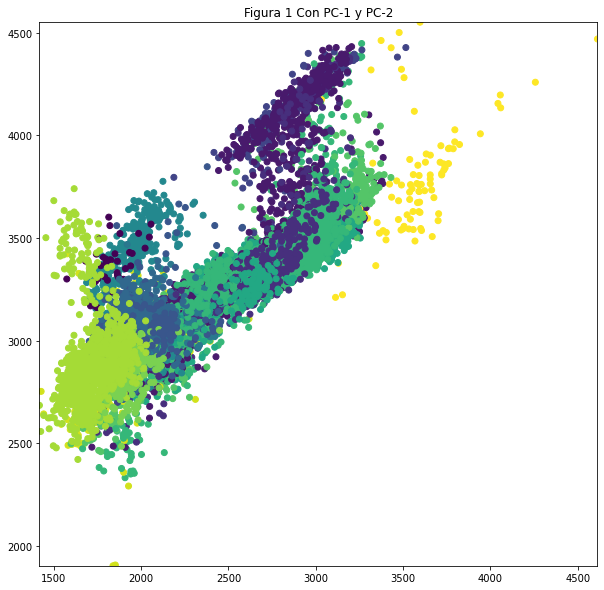

In [ ]:
P = xm@U.T
print(P.shape)

x_min, x_max = P[:, 0].min() , P[:, 0].max()  
y_min, y_max = P[:, 1].min() , P[:, 1].max() 

plt.figure(1,figsize = (10,10))
plt.scatter(P[:,0],P[:,1], c = yl)
plt.title("Figura 1 Con PC-1 y PC-2")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

Como se puede observar en la figura anterior los datos no tieneden a reducirse adecuadamentente.

In [ ]:
P_train, P_test, y_train_P, y_test_P = train_test_split(P, labels_r, test_size=0.2, random_state=0)

Gausian_naive_bayes_PCA = GaussianNB()
Gausian_naive_bayes_PCA.fit(P_train, y_train_P).predict(P_test)
y_pred_pca = Gausian_naive_bayes_PCA.predict(P_test)

precission = accuracy_score(y_test_P,y_pred_pca)


print(f"La precisión alcanzada por el clasificador es: {precission*100} %")

La precisión alcanzada por el clasificador es: 50.4390243902439 %


Teniendo en cuenta el uso del PCA y el clasificador Bayesiano se nota que no hay un cambio significativo en la precisión en comparación del clasificador con todo los datos.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


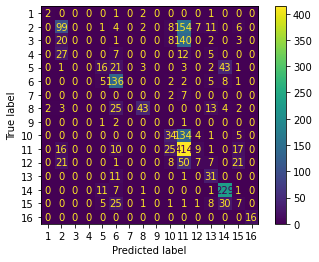

In [ ]:
plot_confusion_matrix(Gausian_naive_bayes_PCA,P_test, y_test_P) 


#Conclusiones.

Al ser un dataset de imágenes hiperespectrales, donde su informacion espectral no tiende a ser lineal y sus bandas o canales estan correlacionadas entre sus pixeles da como resultados datos no linelamente separables, por lo tanto al palicar el clasificador bayesiano no se logra obtener una tendencia que pueda separar adecuadamente los datos.

Y al reducir los datos con PCA los al obtener los valores propios se tienen en cuenta los dos primeros debido a que el resto de ellos van tendioendo a cero y tampoco se logra una disminución de dimensionalidad de los datos  ideal como se pede ver la Figura 1. 

Para hacer una correcta clasificación de los datos se puede optar por una máquina de soporte vectorial o un cualquier otro método de aprendizaje de máquina tradicional y así mejor la precisión de los resultados.